# 08 - Embedding + Batched Priors Basics

Three progressive examples with batched `priors` input:
1. 1D function regression (easy)
2. 2D linear binary classification
3. XOR classification (nonlinear)

All examples optimize only `thetas` and feed data through `priors` in shape `(B, N_prior)`.

In [5]:
from pathlib import Path
import sys
import torch
import matplotlib.pyplot as plt

root = Path.cwd()
if not (root / 'src').exists():
    root = root.parent
sys.path.insert(0, str(root))

from src.pauli_surrogate_python import PauliRotation, CliffordGate, PauliSum
from src_tensor.api import compile_expval_program

if not torch.cuda.is_available():
    raise RuntimeError('This notebook is configured for GPU-only execution, but CUDA is not available.')

torch.manual_seed(0)
device = 'cuda'
dtype = torch.float64

In [6]:
def build_z_observable(n_qubits: int, qubit: int = 0):
    obs = PauliSum(n_qubits)
    obs.add_from_str('Z', 1.0, qubits=[qubit])
    return [obs]

def compile_gpu_program(circuit, observables):
    return compile_expval_program(
        circuit=circuit,
        observables=observables,
        preset='gpu_min',
        preset_overrides={
            'build_device': 'cuda',
            'step_device': 'cuda',
            'stream_device': 'cuda',
            'dtype': 'float64',
            'offload_steps': False,
            'offload_back': False,
            'max_weight': 1_000_000_000,
            'max_xy': 1_000_000_000,
        },
    )

def model_scalar(program, thetas, priors_batch):
    out = program.expvals(thetas, priors=priors_batch, stream_device='cuda', offload_back=False)
    return out[:, 0]

def expv_to_prob(expv):
    expv = torch.nan_to_num(expv, nan=0.0, posinf=1.0, neginf=-1.0)
    return torch.clamp((expv + 1.0) * 0.5, 1e-5, 1.0 - 1e-5)

## 1) 1D function regression (easy)
Fit $y=\sin(x)$ with one embedded feature.

propagate: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


Initial parameter: [0.]
0th parameter: [-0.05]
1D step 0, MSE: 1.000000
80th parameter: [-1.55402182]
1D step 80, MSE: 0.000119
160th parameter: [-1.57078794]
1D step 160, MSE: 0.000000
240th parameter: [-1.57079129]
1D step 240, MSE: 0.000000
320th parameter: [-1.57079635]
1D step 320, MSE: 0.000000
1D final MSE: 6.95225774543329e-19


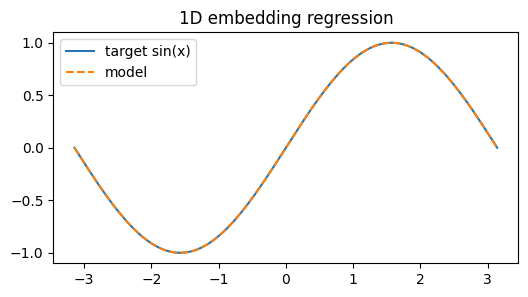

In [7]:
# Use phase-shift form:
# RX(x_embed) -> RX(theta)
# then <Z> = cos(x + theta), which can represent sin(x) exactly because sin(x) = cos(x - pi/2)

circuit_1d = [
    PauliRotation('X', [0], embedding_idx=0),
    PauliRotation('X', [0], param_idx=0),
]

program_1d = compile_gpu_program(circuit_1d, build_z_observable(1, qubit=0))

x = torch.linspace(-3.14159, 3.14159, 128, dtype=dtype, device=device).unsqueeze(1) # (128, 1) -> recognized as (batch, 1)
y = torch.sin(x[:, 0]) # (128,) - make sure target shape matches model output shape for MSE loss

thetas_1d = torch.nn.Parameter(torch.tensor([0.0], dtype=dtype, device=device))
opt_1d = torch.optim.Adam([thetas_1d], lr=0.05)
losses_1d = []

print(f"Initial parameter: {thetas_1d.detach().cpu().numpy()}")
for i in range(400):
    opt_1d.zero_grad(set_to_none=True)
    pred = model_scalar(program_1d, thetas_1d, x) # x = prior_batch
    loss = torch.mean((pred - y) ** 2)
    loss.backward()
    opt_1d.step()
    losses_1d.append(float(loss.detach()))

    if i % 80 == 0:
        print(f"{i}th parameter: {thetas_1d.detach().cpu().numpy()}")
        print(f"1D step {i}, MSE: {losses_1d[-1]:.6f}")

print('1D final MSE:', losses_1d[-1])

with torch.no_grad():
    y_hat = model_scalar(program_1d, thetas_1d, x)

plt.figure(figsize=(6, 3))
plt.plot(x[:, 0].cpu(), y.cpu(), label='target sin(x)')
plt.plot(x[:, 0].cpu(), y_hat.cpu(), '--', label='model')
plt.legend()
plt.title('1D embedding regression')
plt.show()

## 2) 2D linear binary classification
Use $(x_1, x_2)$ as batched priors `(B,2)` and train only `thetas`.

In [8]:
# 2D linear dataset (keep range small to avoid periodic wrap-around issues)
n = 1024
X2 = (torch.rand(n, 2, dtype=dtype, device=device) * 2.0 - 1.0) * 1.2 # (0, 1) -> (-1, 1) scaled to (-1.2, 1.2)
y2 = ((X2[:, 0] + X2[:, 1]) > 0).to(dtype)

# Feature map matched to linear boundary:
# RY(x1) -> RY(x2) -> RY(theta) on one qubit gives angle (x1 + x2 + theta)
# Measure Z so output is cos(x1 + x2 + theta), whose sign gives a linear separator.
circuit_2d = [
    PauliRotation('Y', [0], embedding_idx=0),
    PauliRotation('Y', [0], embedding_idx=1),
    PauliRotation('Y', [0], param_idx=0),
]

obs2 = PauliSum(1)
obs2.add_from_str('Z', 1.0, qubits=[0])
program_2d = compile_gpu_program(circuit_2d, [obs2])

thetas_2d = torch.nn.Parameter(torch.tensor([0.0], dtype=dtype, device=device))
opt_2d = torch.optim.Adam([thetas_2d], lr=0.03)
batch_size = 128

for epoch in range(180):
    perm = torch.randperm(n, device=device)
    for s in range(0, n, batch_size):
        idx = perm[s:s + batch_size]
        xb = X2[idx]
        yb = y2[idx]

        opt_2d.zero_grad(set_to_none=True)
        expv = model_scalar(program_2d, thetas_2d, xb)
        prob = expv_to_prob(expv)
        loss = torch.nn.functional.binary_cross_entropy(prob, yb)

        if not torch.isfinite(loss): # loss가 NaN이거나 Inf인 경우 그 배치 업데이트를 건너뜀
            continue

        loss.backward()

        if thetas_2d.grad is None or (not torch.isfinite(thetas_2d.grad).all()): # 기울기가 NaN이거나 Inf인 경우 업데이트 건너뜀
            opt_2d.zero_grad(set_to_none=True)
            continue

        torch.nn.utils.clip_grad_norm_([thetas_2d], max_norm=5.0) # L2 norm을 계산해서 5.0을 넘으면 norm을 5.0으로 스케일링. 이하면 그대로 둠
        opt_2d.step()

        with torch.no_grad():
            thetas_2d.data = torch.nan_to_num(thetas_2d.data, nan=0.0, posinf=0.0, neginf=0.0)

    if epoch % 30 == 0:
        with torch.no_grad():
            p_eval = expv_to_prob(model_scalar(program_2d, thetas_2d, X2))
            acc_eval = ((p_eval >= 0.5).to(dtype) == y2).to(dtype).mean().item()
        print(f'2D epoch {epoch:3d} | loss {float(loss.detach()):.4f} | acc {acc_eval:.4f}')

with torch.no_grad():
    p_all = expv_to_prob(model_scalar(program_2d, thetas_2d, X2))
    acc2 = ((p_all >= 0.5).to(dtype) == y2).to(dtype).mean().item()

print('2D linear classification accuracy:', acc2)
print('learned theta:', thetas_2d.detach().cpu().numpy())

propagate:   0%|          | 0/3 [00:00<?, ?it/s]

propagate: 100%|██████████| 3/3 [00:00<00:00, 46.61it/s]


2D epoch   0 | loss 0.9207 | acc 0.5654
2D epoch  30 | loss 0.2576 | acc 0.9961
2D epoch  60 | loss 0.2472 | acc 0.9971
2D epoch  90 | loss 0.2417 | acc 0.9941
2D epoch 120 | loss 0.2435 | acc 0.9971
2D epoch 150 | loss 0.2686 | acc 0.9961
2D linear classification accuracy: 0.99609375
learned theta: [-1.55065525]


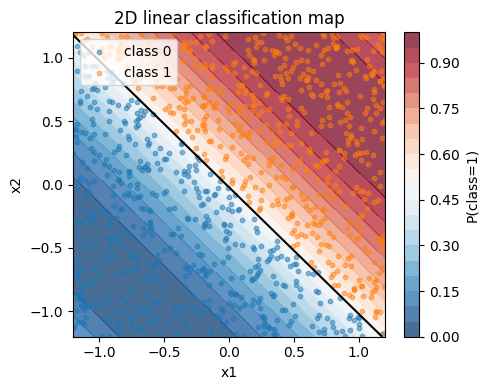

In [9]:
# 2D classification visualization (probability field + labeled samples)
grid_lin = torch.linspace(-1.2, 1.2, 180, dtype=dtype, device=device)
gx, gy = torch.meshgrid(grid_lin, grid_lin, indexing='xy') # 
grid = torch.stack([gx.reshape(-1), gy.reshape(-1)], dim=1) # (num_points, 2)

with torch.no_grad():
    p_grid = expv_to_prob(model_scalar(program_2d, thetas_2d, grid))
p_img = p_grid.reshape(gx.shape).cpu().numpy()
levels = torch.linspace(0.0, 1.0, 21).cpu().numpy()

plt.figure(figsize=(5, 4))
cf = plt.contourf(gx.cpu().numpy(), gy.cpu().numpy(), p_img, levels=levels, cmap='RdBu_r', alpha=0.75) # 확률 분포를 색으로 채워서 그림
plt.contour(gx.cpu().numpy(), gy.cpu().numpy(), p_img, levels=[0.5], colors='k', linewidths=1.5)
plt.colorbar(cf, label='P(class=1)')

X2_np = X2.cpu().numpy()
y2_np = y2.cpu().numpy()
plt.scatter(X2_np[y2_np < 0.5, 0], X2_np[y2_np < 0.5, 1], s=10, alpha=0.5, label='class 0')
plt.scatter(X2_np[y2_np >= 0.5, 0], X2_np[y2_np >= 0.5, 1], s=10, alpha=0.5, label='class 1')

plt.title('2D linear classification map')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 3) XOR classification (nonlinear)
Shows a harder nonlinearly separable task.

In [10]:
n_xor = 512
Xx = (torch.rand(n_xor, 2, dtype=dtype, device=device) * 2.0 - 1.0) * 3.14159 # (0,1) -> (-1, 1) -> (-pi, pi)
yx = ((Xx[:, 0] * Xx[:, 1]) < 0).to(dtype) # XOR labels

circuit_xor = [
    PauliRotation('X', [0], embedding_idx=0),
    PauliRotation('X', [1], embedding_idx=1),
    CliffordGate('CNOT', [0, 1]),
    PauliRotation('Y', [0], param_idx=0),
    PauliRotation('Y', [1], param_idx=1),
    CliffordGate('CNOT', [1, 0]),
    PauliRotation('Z', [0], param_idx=2),
]
program_xor = compile_gpu_program(circuit_xor, build_z_observable(2, qubit=0))

thetas_xor = torch.nn.Parameter(torch.randn(3, dtype=dtype, device=device) * 0.1) # trainable parameters
opt_xor = torch.optim.Adam([thetas_xor], lr=0.03)

for epoch in range(320):
    perm = torch.randperm(n_xor, device=device)
    for s in range(0, n_xor, batch_size):
        idx = perm[s:s + batch_size]
        xb = Xx[idx]
        yb = yx[idx]

        opt_xor.zero_grad(set_to_none=True)
        expv = model_scalar(program_xor, thetas_xor, xb)
        prob = expv_to_prob(expv)
        loss = torch.nn.functional.binary_cross_entropy(prob, yb)

        if not torch.isfinite(loss):
            continue

        loss.backward()

        if thetas_xor.grad is None or (not torch.isfinite(thetas_xor.grad).all()):
            opt_xor.zero_grad(set_to_none=True)
            continue

        torch.nn.utils.clip_grad_norm_([thetas_xor], max_norm=5.0)
        opt_xor.step()

        with torch.no_grad():
            thetas_xor.data = torch.nan_to_num(thetas_xor.data, nan=0.0, posinf=0.0, neginf=0.0)

    if epoch % 40 == 0:
        with torch.no_grad():
            p_eval = expv_to_prob(model_scalar(program_xor, thetas_xor, Xx))
            acc_eval = ((p_eval >= 0.5).to(dtype) == yx).to(dtype).mean().item()
        print(f'XOR epoch {epoch:3d} | loss {float(loss.detach()):.4f} | acc {acc_eval:.4f}')

with torch.no_grad():
    p_xor = expv_to_prob(model_scalar(program_xor, thetas_xor, Xx))
    acc_xor = ((p_xor >= 0.5).to(dtype) == yx).to(dtype).mean().item()
print('XOR classification accuracy:', acc_xor)

propagate: 100%|██████████| 7/7 [00:00<00:00, 104.56it/s]


XOR epoch   0 | loss 1.2828 | acc 0.4980
XOR epoch  40 | loss 0.3644 | acc 0.9492
XOR epoch  80 | loss 0.4030 | acc 0.9531
XOR epoch 120 | loss 0.3737 | acc 0.9590
XOR epoch 160 | loss 0.3810 | acc 0.9609
XOR epoch 200 | loss 0.3769 | acc 0.9531
XOR epoch 240 | loss 0.3845 | acc 0.9512
XOR epoch 280 | loss 0.4051 | acc 0.9688
XOR classification accuracy: 0.94921875


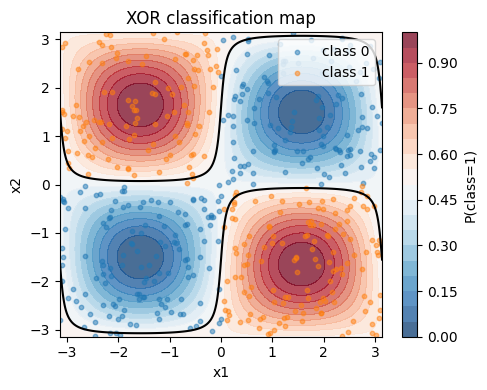

In [11]:
# XOR classification visualization (probability field + labeled samples)
grid_lin = torch.linspace(-3.14159, 3.14159, 220, dtype=dtype, device=device)
gx, gy = torch.meshgrid(grid_lin, grid_lin, indexing='xy')
grid = torch.stack([gx.reshape(-1), gy.reshape(-1)], dim=1)

with torch.no_grad():
    p_grid = expv_to_prob(model_scalar(program_xor, thetas_xor, grid))
p_img = p_grid.reshape(gx.shape).cpu().numpy()
levels = torch.linspace(0.0, 1.0, 21).cpu().numpy()

plt.figure(figsize=(5, 4))
cf = plt.contourf(gx.cpu().numpy(), gy.cpu().numpy(), p_img, levels=levels, cmap='RdBu_r', alpha=0.75)
plt.contour(gx.cpu().numpy(), gy.cpu().numpy(), p_img, levels=[0.5], colors='k', linewidths=1.5)
plt.colorbar(cf, label='P(class=1)')

Xx_np = Xx.cpu().numpy()
yx_np = yx.cpu().numpy()
plt.scatter(Xx_np[yx_np < 0.5, 0], Xx_np[yx_np < 0.5, 1], s=10, alpha=0.5, label='class 0')
plt.scatter(Xx_np[yx_np >= 0.5, 0], Xx_np[yx_np >= 0.5, 1], s=10, alpha=0.5, label='class 1')

plt.title('XOR classification map')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Notes
- Inputs are batched with `priors` shape `(B, N_prior)`.
- Trainable parameters are only `thetas`.
- To try GPU, change preset overrides to CUDA devices.